In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import sys

from skimage.io import imread
from matplotlib import pyplot as plt

import os
#os.environ['KERAS_BACKEND'] = 'theano'
#os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN, device=gpu0, floatX=float32, optimizer=fast_compile'

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

from keras import models
from keras.optimizers import SGD
from keras import backend as K

import random

Using TensorFlow backend.


In [2]:
path = 'Intcatch_Dataset_Water_Resized/'
img_w = 240
img_h = 160
n_labels = 2 #6
#n_of_images= 191*2
data_shape = img_w*img_h

def normalized(bgr):
    #return rgb/255.0
    #norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    #b=rgb[:,:,0]
    #g=rgb[:,:,1]
    #r=rgb[:,:,2]

    #norm[:,:,0]=cv2.equalizeHist(b)
    #norm[:,:,1]=cv2.equalizeHist(g)
    #norm[:,:,2]=cv2.equalizeHist(r)

    #return norm

    b, g, r = cv2.split(bgr)
    red = cv2.equalizeHist(r)
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((blue, green, red))

In [3]:
import os
from keras.models import model_from_json

# load json and create model
json_file = open('modelli/modello_halfConv_240x160.json', 'r')
model = json_file.read()
json_file.close()
model = model_from_json(model)
# load weights into new model
model.load_weights("weights/best2_halfConv_240x160-90Epochs.hdf5")
print("Loaded model from disk")

Loaded model from disk


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline


NoLabel = [0,0,0]

Water = [255,100,100] 

Sky = [153,17,105] 

Mountain = [0,255,0] 

Boat = [200,8,21] 

Other = [255,255,255] 

label_colours = np.array([NoLabel, Water, Sky, Mountain, Boat,
                          Other])

def visualize(temp, plot=False):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,5):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3), dtype=np.uint8)
    rgb[:,:,0] = (b)#[:,:,0]
    rgb[:,:,1] = (g)#[:,:,1]
    rgb[:,:,2] = (r)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb
        
        
import math

line=[]

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def median_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.medianBlur(img, kernel_size)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_fitline(img, f_lines):

    rows,cols = img.shape[:2]
    output = cv2.fitLine(f_lines,cv2.DIST_L2,0, 0.01, 0.01)
    vx, vy, x, y = output[0], output[1], output[2], output[3]
    x1, y1 = int(((img.shape[0]-1)-y)/vy*vx + x) , img.shape[0]-1
    x2, y2 = int(((img.shape[0]/2+100)-y)/vy*vx + x) , int(img.shape[0]/2+100)
    result = [x1,y1,x2,y2]

    return result


def draw_lines(img, lines, color=[255, 255, 255], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)

    
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def Collect_points(lines):

    # reshape [:4] to [:2]
    #interp = lines.reshape(lines.shape[0]*2,2)
    # interpolation & collecting points for RANSAC
    points=[]
    for line in lines:
        #print(line[0],line[1],line[2],line[3])
        #if(int(line[1])<400):
        new_point = np.array([[int(line[0]),int(line[1])]])
        points.append(new_point)
        #interp = np.concatenate((interp,new_point),axis = 0)
        #if(int(line[3])<400):
        new_point = np.array([[int(line[2]),int(line[3])]])
        points.append(new_point)
        #interp = np.concatenate((interp,new_point),axis = 0)
    return points

def printPoints(points):
    for point in points:
        print(point)

def draw_circle(img,points, color=[255, 255, 255]):
    for point in points:
        cv2.circle(img,(point[0],point[1]), 2, color, -1)
        
def smoothing(lines, pre_frame=10):
    # collect frames & print average line
    lines = np.squeeze(lines)
    avg_line = np.array([0.0,0.0,0.0,0.0])
    
    for ii,line in enumerate(reversed(lines)):
        if ii == pre_frame:
            break
        avg_line += line
    avg_line = avg_line / pre_frame

    return avg_line

def horizon_line_pipeline(image):
    #image=median_blur(image,101)  #ATTENTION
    gray = grayscale(image)
    gray=median_blur(gray, 21)  #ATTENTION
    low_threshold = 0
    high_threshold = 0
    cannyimage=canny(gray, low_threshold, high_threshold)
    rho = 2# distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 2 #minimum number f pixels making up a line
    max_line_gap = 5    # maximum gap in pixels between connectable line segments
    lines=hough_lines(cannyimage, rho, theta, threshold, min_line_length, max_line_gap)
    line_arr = np.squeeze(lines)
    #slope_degree = (np.arctan2(line_arr[:,1] - line_arr[:,3], line_arr[:,0] - line_arr[:,2]) * 180) / np.pi
    # ignore vertical slope lines
    #line_arr = line_arr[np.abs(slope_degree)>95]
    points = Collect_points(line_arr)
    if(len(points)<2):
        points= line_arr.reshape(lines.shape[0]*2,2)
        
    #printPoints(points)
    #line_img = np.zeros((cannyimage.shape[0], cannyimage.shape[1], 3), dtype=np.uint8)
    #draw_circle(line_img,points)
    if(len(points)>2):
        fit_line = cv2.fitLine(np.float32(points), cv2.DIST_HUBER, 1, 0.001, 0.001)
        line.append(fit_line)
    
        #if len(line) > 10:
        #    fit_line = smoothing(line, 1)
        
    
        
    
    return fit_line
    

0 0.0
1 1.3979332447052002
2 1.4146347045898438
3 1.4340879917144775
4 1.4502074718475342
5 1.4663233757019043
6 1.4824059009552002
7 1.506241798400879


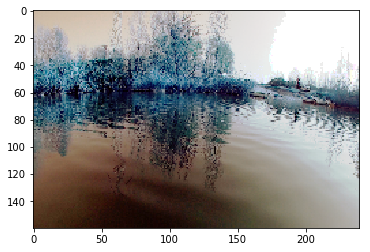

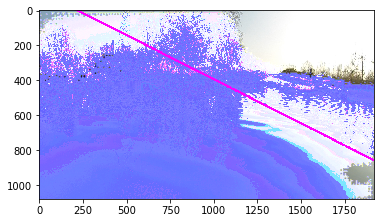

8 2.3270981311798096
9 2.3667168617248535
10 2.386296272277832
11 2.415983200073242
12 2.4313576221466064
13 2.4480667114257812
14 2.467912435531616


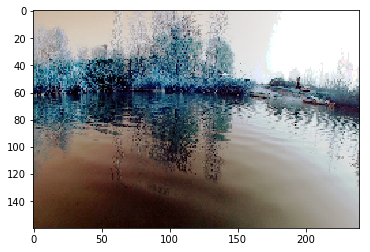

OSError: [Errno 32] Broken pipe

FFMPEG COMMAND:
ffmpeg -y -f rawvideo -vcodec rawvideo -s 1920x1080 -pix_fmt rgb24 -r 9.00 -i - -an -vcodec libx264 -pix_fmt yuv420p -crf 25 -r 9 -vf scale=1920:1088 -v warning /home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/video_output/TMP.mp4

FFMPEG STDERR OUTPUT:


In [6]:
import imageio
from time import time, sleep


filename = "video_input/prophr3.mp4"
reader = imageio.get_reader(filename,  'ffmpeg')
fps = reader.get_meta_data()['fps']
writer = imageio.get_writer('video_output/TMP.mp4', fps=9)
now=time()
start_time=now

image=reader.get_data(0)
image = np.array(image)
image = image[:, :, ::-1].copy()
image_original=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height,width,depth=image.shape
image_original_hist=normalized(image_original)
image = cv2.resize(image,(img_w,img_h))
image = normalized(image)
image = image[np.newaxis, ...]
output = model.predict(image)
pred = visualize(np.argmax(output[0],axis=1).reshape((img_h,img_w)), False)
pred_original_size = cv2.resize(pred,(width,height))
pred_original_size=horizon_line_pipeline(pred_original_size)

prediction_framerate=7
for i in range(len(reader)):
    elapsed_time = now - start_time
    print(i, elapsed_time)
    image=reader.get_data(int(i))
    image = np.array(image)
    image = image[:, :, ::-1].copy()
    image_original=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if(i==prediction_framerate):
        height,width,depth=image.shape
        image = cv2.resize(image,(img_w,img_h))
        image = normalized(image)
        plt.imshow(image)
        plt.show()
        image = image[np.newaxis, ...]
        output = model.predict(image)
        pred = visualize(np.argmax(output[0],axis=1).reshape((img_h,img_w)), False)
        pred_original_size = cv2.resize(pred,(width,height))
        fit_line = horizon_line_pipeline(pred_original_size)
        prediction_framerate+=7
        imageOUT = cv2.bitwise_or(image_original,pred_original_size)
        cv2.line(imageOUT, (int(fit_line[2]-fit_line[0]*width), int(fit_line[3]-fit_line[1]*width)), (int(fit_line[2]+fit_line[0]*width), int(fit_line[3]+fit_line[1]*width)), (255, 0, 255), 12)
        writer.append_data(imageOUT)
        plt.imshow(imageOUT)
        plt.show()
    now=time()
    if(i>=5018): break
writer.close()

# 160 x 160

In [4]:
import glob
dataset_annotation=glob.glob("/home/lorenzo/Intcatch/definitivo/Test/*annotation.png", recursive=True)

Path_to_save_image='Results/Full_image/Big_Conv_80x80/Image_Results/'
Path_to_save_results='Results/Full_image/Big_Conv_80x80/'

label=[]
pred=[]
index=0
for annotation in dataset_annotation:
    index+=1
    #if(index==2): break
    print(index," - ",len(dataset_annotation))
    pathRoot=annotation[:annotation.rfind('/')] + '/'
    name_file=(annotation[annotation.rfind('/')+1 : annotation.rfind('-annotation')])
    annotation_image=cv2.imread(annotation)
    name_of_image=Path_to_save_image+ name_file +'-Mask.png'
    cv2.imwrite(name_of_image,annotation_image)
    
    
    annotation_image = cv2.cvtColor(annotation_image, cv2.COLOR_BGR2RGB)
    annotation_image = cv2.resize(annotation_image,(img_h,img_w))
    image=cv2.imread(pathRoot+name_file+".png")
    image_original=image
    name_of_image=Path_to_save_image + name_file +'.png'
    cv2.imwrite(name_of_image,image)
    image = np.array(image)
    height,width,depth=image.shape
    image = cv2.resize(image,(img_w,img_h))
    image = normalized(image)
    image = image[np.newaxis, ...]
    output = model.predict(image)
    
    pred_output_image = visualize(np.argmax(output[0],axis=1).reshape((img_h,img_w)), False)
    pred_output_image = cv2.resize(pred_output_image,(width,height))
    pred_output_image = cv2.cvtColor(pred_output_image, cv2.COLOR_BGR2RGB)
    name_of_image=Path_to_save_image+ name_file +'-Mask_Predicted.png'
    cv2.imwrite(name_of_image, pred_output_image)
    
    imageOUT = cv2.bitwise_or(image_original,pred_output_image)
    fit_line = horizon_line_pipeline(pred_output_image)
    cv2.line(imageOUT, (int(fit_line[2]-fit_line[0]*width), int(fit_line[3]-fit_line[1]*width)), (int(fit_line[2]+fit_line[0]*width), int(fit_line[3]+fit_line[1]*width)), (255, 0, 255), 10)
    
    
    name_of_image=Path_to_save_image+ name_file +'-Horizon.png'
    cv2.imwrite(name_of_image,imageOUT)
    
    result_softmax=output[0].reshape(img_h,img_w,2)
    height_softmax,width_softmax=result_softmax.shape[:2]
    softmax_image=result_softmax[:,:,1]
    
    if(False):
        height,width,depth=annotation_image.shape
        fit_line = horizon_line_pipeline(annotation_image)
        line_annotation_image = np.zeros([height,width], dtype = "uint8")
        cv2.line(line_annotation_image, (int(fit_line[2]-fit_line[0]*width), int(fit_line[3]-fit_line[1]*width)), (int(fit_line[2]+fit_line[0]*width), int(fit_line[3]+fit_line[1]*width)), (255, 255, 255), 1)
        for i in range (height):
            if(line_annotation_image[i,0]==255):
                y1=i
                break
        
        for i in range (height):
            if(line_annotation_image[i,width-1]==255):
                y2=i
                break
            
        avg_y= int((y1+y2)/2)
        
        annotation_image = annotation_image[avg_y-10:avg_y+10, 0:width]
        softmax_image = softmax_image[avg_y-10:avg_y+10, 0:width]
        
        


    
            
    
    
    
    #prediction_image = visualize(np.argmax(output[0],axis=1).reshape((img_h,img_w)), False)
    #prediction_image = cv2.resize(softmax_image,(width,height))
    
    
    height,width=annotation_image.shape[:2]
    annotation = np.zeros([height,width])
    for i in range(height):
        for j in range(width):
            if(np.array_equal(annotation_image[i,j],(100,100,255))):
                annotation[i,j]=1
                
    #image_sub=np.subtract(annotation,softmax_image)
    Threshold=0.5
    results = np.zeros([height,width,3],dtype=np.uint8)
    softmax_image[np.where(softmax_image<Threshold)]=0
    softmax_image[np.where(softmax_image>=Threshold)]=1
    #results[np.where((annotation==0)&(softmax_image==0))]=()
    #print(np.where((annotation==0)&(softmax_image==0)))
    #plt.imshow(softmax_image)
    #plt.show()
    
    for i in range(height):
        for j in range(width):
            if(annotation[i,j]==0 and softmax_image[i,j]==0):
                results[i,j,:]=np.array([0,0,0])
            if(annotation[i,j]==1 and softmax_image[i,j]==0):
                results[i,j,:]=np.array([0,0,255])
            if(annotation[i,j]==0 and softmax_image[i,j]==1):
                results[i,j,:]=np.array([0,255,0])
            if(annotation[i,j]==1 and softmax_image[i,j]==1):
                results[i,j,:]=np.array([255,255,255])
                
    
    results_output = cv2.resize(results,(1280,720))
    name_of_image= Path_to_save_image + name_file +'-Score.png'
    cv2.imwrite(name_of_image,cv2.cvtColor(results_output, cv2.COLOR_BGR2RGB))

    
    
            
            
                
                
    label=np.concatenate((label, annotation.flatten()), axis=0)
    pred=np.concatenate((pred, np.round(softmax_image.flatten(),1)), axis=0)
    


#print(label.shape)
#print(pred.shape)

#tmp=np.subtract(label,pred)

#plt.hist(tmp, facecolor='green')

#pred=np.round(pred)
Threshold=0.5
pred[np.where(pred<Threshold)]=0
pred[np.where(pred>=Threshold)]=1
True_neg=len(np.where((label==0)&(pred==0))[0])
False_neg=len(np.where((label==1)&(pred==0))[0])
True_pos=len(np.where((label==1)&(pred==1))[0])
False_pos=len(np.where((label==0)&(pred==1))[0])
precision=True_pos/(True_pos+False_pos)
recall=True_pos/(True_pos+False_neg)
specificity=1-(True_neg/(True_neg+False_pos))
accuracy=(True_pos+True_neg)/(True_pos+True_neg+False_pos+False_neg)
f1score=2*(precision*recall)/(precision+recall)

print("recall = ",recall)
print("precision = ",precision)
print("specificity = ",specificity)
print("accuracy = ",accuracy)
print("f1score =",f1score)


with open(os.path.abspath(Path_to_save_results + "Results.txt"), "a") as myfile:
        myfile.write("recall = " + str(recall)+"\n")
        myfile.write("precision = " + str(precision)+"\n")
        myfile.write("specificity = " + str(specificity)+"\n")
        myfile.write("accuracy = " + str(accuracy)+"\n")
        myfile.write("f1score = " + str(f1score)+"\n")

    

1  -  87


NameError: name 'visualize' is not defined

# Cropped Results

In [7]:
import glob
dataset_annotation=glob.glob("/home/lorenzo/Intcatch/definitivo/Test/*annotation.png", recursive=True)

Path_to_save_image='Results/Cropped_image/Big_Conv_160x160/Image_Results/'
Path_to_save_results='Results/Cropped_image/Big_Conv_160x160/'
Flag_Save=True

label=[]
pred=[]
index=0
for annotation in dataset_annotation:
    index+=1
    #if(index==2): break
    print(index," - ",len(dataset_annotation))
    pathRoot=annotation[:annotation.rfind('/')] + '/'
    name_file=(annotation[annotation.rfind('/')+1 : annotation.rfind('-annotation')])
    annotation_image=cv2.imread(annotation)
    annotation_image_output=annotation_image
    
    
    annotation_image = cv2.cvtColor(annotation_image, cv2.COLOR_BGR2RGB)
    annotation_image = cv2.resize(annotation_image,(img_h,img_w))
    image=cv2.imread(pathRoot+name_file+".png")
    image_output=image
    image = np.array(image)
    height,width,depth=image.shape
    image = cv2.resize(image,(img_w,img_h))
    image = normalized(image)
    image = image[np.newaxis, ...]
    output = model.predict(image)
    
    pred_output_image = visualize(np.argmax(output[0],axis=1).reshape((img_h,img_w)), False)
    
    
    #fit_line = horizon_line_pipeline(pred_output_image)
    #cv2.line(pred_output_image, (int(fit_line[2]-fit_line[0]*width), int(fit_line[3]-fit_line[1]*width)), (int(fit_line[2]+fit_line[0]*width), int(fit_line[3]+fit_line[1]*width)), (255, 255, 255), 10)
    #imageOUT = cv2.bitwise_or(image_original,pred_output_image)
    
   
    
    result_softmax=output[0].reshape(img_h,img_w,2)
    height_softmax,width_softmax=result_softmax.shape[:2]
    softmax_image=result_softmax[:,:,1]
    
    if(True):
        height,width,depth=annotation_image.shape
        fit_line = horizon_line_pipeline(annotation_image)
        line_annotation_image = np.zeros([height,width], dtype = "uint8")
        cv2.line(line_annotation_image, (int(fit_line[2]-fit_line[0]*width), int(fit_line[3]-fit_line[1]*width)), (int(fit_line[2]+fit_line[0]*width), int(fit_line[3]+fit_line[1]*width)), (255, 255, 255), 1)
        for i in range (height):
            if(line_annotation_image[i,0]==255):
                y1=i
                break
        
        for i in range (height):
            if(line_annotation_image[i,width-1]==255):
                y2=i
                break
            
        avg_y= int((y1+y2)/2)
        
        annotation_image = annotation_image[avg_y-15:avg_y+15, 0:width]
        softmax_image = softmax_image[avg_y-15:avg_y+15, 0:width]
        
        


    
            
    
    
    
    #prediction_image = visualize(np.argmax(output[0],axis=1).reshape((img_h,img_w)), False)
    #prediction_image = cv2.resize(softmax_image,(width,height))
    
    height,width=annotation_image.shape[:2]
    annotation = np.zeros([height,width])
    for i in range(height):
        for j in range(width):
            if(np.array_equal(annotation_image[i,j],(100,100,255))):
                annotation[i,j]=1
                
    #image_sub=np.subtract(annotation,softmax_image)
    Threshold=0.5
    results = np.zeros([height,width,3],dtype=np.uint8)
    softmax_image[np.where(softmax_image<Threshold)]=0
    softmax_image[np.where(softmax_image>=Threshold)]=1
    #results[np.where((annotation==0)&(softmax_image==0))]=()
    #print(np.where((annotation==0)&(softmax_image==0)))
    #plt.imshow(softmax_image)
    #plt.show()
    
    for i in range(height):
        for j in range(width):
            if(annotation[i,j]==0 and softmax_image[i,j]==0):
                results[i,j,:]=np.array([0,0,0])
            if(annotation[i,j]==1 and softmax_image[i,j]==0):
                results[i,j,:]=np.array([0,0,255])
            if(annotation[i,j]==0 and softmax_image[i,j]==1):
                results[i,j,:]=np.array([0,255,0])
            if(annotation[i,j]==1 and softmax_image[i,j]==1):
                results[i,j,:]=np.array([255,255,255])
                
                
    if(Flag_Save==True):
        
        name_of_image=Path_to_save_image+ name_file +'-Mask_Horizon.png'
        output=cv2.resize(annotation_image_output,(1280,180))
        cv2.imwrite(name_of_image,output)
        
        name_of_image=Path_to_save_image+ name_file +'-Mask_Predicted_Horizon.png'
        output=cv2.resize(pred_output_image[avg_y-15:avg_y+15, 0:width],(1280,180))
        cv2.imwrite(name_of_image,cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

        results_output = results
        name_of_image= Path_to_save_image + name_file +'-Score_Horizon.png'
        output=cv2.resize(results_output,(1280,180))
        cv2.imwrite(name_of_image,cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    
    

    
    
            
            
                
                
    label=np.concatenate((label, annotation.flatten()), axis=0)
    pred=np.concatenate((pred, np.round(softmax_image.flatten(),1)), axis=0)
    


#print(label.shape)
#print(pred.shape)

#tmp=np.subtract(label,pred)

#plt.hist(tmp, facecolor='green')

#pred=np.round(pred)
Threshold=0.5
pred[np.where(pred<Threshold)]=0
pred[np.where(pred>=Threshold)]=1
True_neg=len(np.where((label==0)&(pred==0))[0])
False_neg=len(np.where((label==1)&(pred==0))[0])
True_pos=len(np.where((label==1)&(pred==1))[0])
False_pos=len(np.where((label==0)&(pred==1))[0])
precision=True_pos/(True_pos+False_pos)
recall=True_pos/(True_pos+False_neg)
specificity=1-(True_neg/(True_neg+False_pos))
accuracy=(True_pos+True_neg)/(True_pos+True_neg+False_pos+False_neg)
f1score=2*(precision*recall)/(precision+recall)

print("recall = ",recall)
print("precision = ",precision)
print("specificity = ",specificity)
print("accuracy = ",accuracy)
print("f1score =",f1score)


with open(os.path.abspath(Path_to_save_results + "Results.txt"), "a") as myfile:
        myfile.write("recall = " + str(recall)+"\n")
        myfile.write("precision = " + str(precision)+"\n")
        myfile.write("specificity = " + str(specificity)+"\n")
        myfile.write("accuracy = " + str(accuracy)+"\n")
        myfile.write("f1score = " + str(f1score)+"\n")

    

1  -  87
2  -  87
3  -  87
4  -  87
5  -  87
6  -  87
7  -  87
8  -  87
9  -  87
10  -  87
11  -  87
12  -  87
13  -  87
14  -  87
15  -  87
16  -  87
17  -  87
18  -  87
19  -  87
20  -  87
21  -  87
22  -  87
23  -  87
24  -  87
25  -  87
26  -  87
27  -  87
28  -  87
29  -  87
30  -  87
31  -  87
32  -  87
33  -  87
34  -  87
35  -  87
36  -  87
37  -  87
38  -  87
39  -  87
40  -  87
41  -  87
42  -  87
43  -  87
44  -  87
45  -  87
46  -  87
47  -  87
48  -  87
49  -  87
50  -  87
51  -  87
52  -  87
53  -  87
54  -  87
55  -  87
56  -  87
57  -  87
58  -  87
59  -  87
60  -  87
61  -  87
62  -  87
63  -  87
64  -  87
65  -  87
66  -  87
67  -  87
68  -  87
69  -  87
70  -  87
71  -  87
72  -  87
73  -  87
74  -  87
75  -  87
76  -  87
77  -  87
78  -  87
79  -  87
80  -  87
81  -  87
82  -  87
83  -  87
84  -  87
85  -  87
86  -  87
87  -  87
recall =  0.9590510533715402
precision =  0.9210199485696912
specificity =  0.06627574098579003
accuracy =  0.9450263409961686
f1score = 0.

(9600,)
average done
[ 0.80095193  0.75951696]


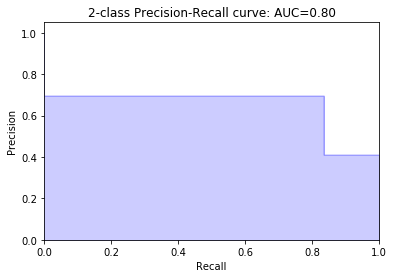

In [85]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, f1_score

average_precision = average_precision_score(label, pred)
print(label.shape)

print("average done")

precision, recall, treshold = precision_recall_curve(label, pred)
#print(precision)
#print(recall)
#print(treshold)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(average_precision))
prediction=np.round(pred)
f1=f1_score(label, prediction, average=None)

print(f1)

# Segmentation on the Horizon line Acuracy

In [ ]:
import glob
dataset_annotation=glob.glob("/home/lorenzo/Intcatch/definitivo/Test/*annotation.png", recursive=True)
label=[]
pred=[]
index=0
for annotation in dataset_annotation:
    index+=1
    print(index," - ",len(annotation))
    pathRoot=annotation[:annotation.rfind('/')] + '/'
    name_file=(annotation[annotation.rfind('/')+1 : annotation.rfind('-annotation')])
    image=cv2.imread(pathRoot+name_file+".png")
    image = np.array(image)
    height,width,depth=image.shape
    
    
    annotation_image=cv2.imread(annotation)
    annotation_image = cv2.cvtColor(annotation_image, cv2.COLOR_BGR2RGB)
    
    fit_line = horizon_line_pipeline(annotation_image)
    line_annotation_image = np.zeros([height,width], dtype = "uint8")
    cv2.line(line_annotation_image, (int(fit_line[2]-fit_line[0]*width), int(fit_line[3]-fit_line[1]*width)), (int(fit_line[2]+fit_line[0]*width), int(fit_line[3]+fit_line[1]*width)), (255, 255, 255), 1)
    
    for i in range (height):
        if(line_annotation_image[i,0]==255):
            y1=i
            break
        
    for i in range (height):
        if(line_annotation_image[i,width-1]==255):
            y2=i
            break
            
    avg_y= int((y1+y2)/2)
    
    
    image = cv2.resize(image,(img_w,img_h))
    image = normalized(image)
    image = image[np.newaxis, ...]
    output = model.predict(image)
    
    
    prediction_image = visualize(np.argmax(output[0],axis=1).reshape((img_h,img_w)), False)
    prediction_image = cv2.resize(prediction_image,(width,height))
    fit_line = horizon_line_pipeline(prediction_image)
    line_prediction_image = np.zeros([height,width], dtype = "uint8")
    cv2.line(line_prediction_image, (int(fit_line[2]-fit_line[0]*width), int(fit_line[3]-fit_line[1]*width)), (int(fit_line[2]+fit_line[0]*width), int(fit_line[3]+fit_line[1]*width)), (255, 255, 255), 1)
    
    annotation_image_crop = annotation_image[avg_y-100:avg_y+100, 0:width]
    prediction_image_crop = prediction_image[avg_y-100:avg_y+100, 0:width]
    
    height,width=annotation_image_crop.shape[:2]
    annotation = np.zeros([height,width], dtype = "uint8")
    for i in range(height):
        for j in range(width):
            if(np.array_equal(annotation_image[i,j],(100,100,255))):
                annotation[i,j]=1
                            
    height,width=prediction_image_crop.shape[:2]
    prediction = np.zeros([height,width], dtype = "uint8")
    for i in range(height):
        for j in range(width):
            if(np.array_equal(prediction_image[i,j],(100,100,255))):
                prediction[i,j]=1
                
                
                
    label=np.concatenate((label, annotation.flatten()), axis=0)
    pred=np.concatenate((pred, prediction.flatten()), axis=0)
    
    
    
    

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
print(len(label))
print(len(pred))
average_precision = average_precision_score(label, pred)


precision, recall, _ = precision_recall_curve(label, pred)

print(precision)
print(recall)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          average_precision))




# line Acuracy residual

1  -  87
2  -  87


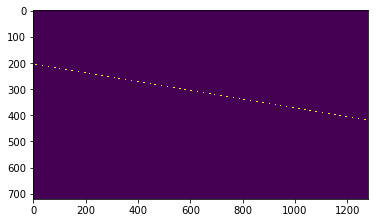

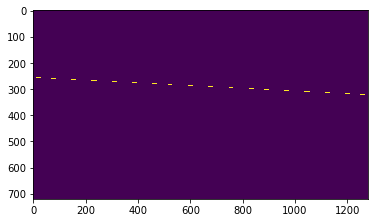

3  -  87


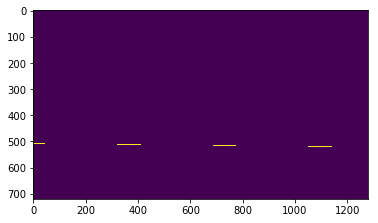

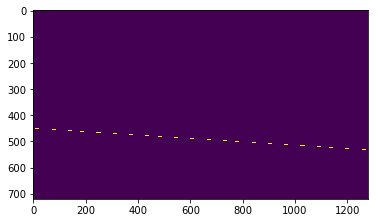

4  -  87
5  -  87


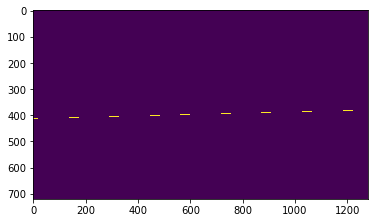

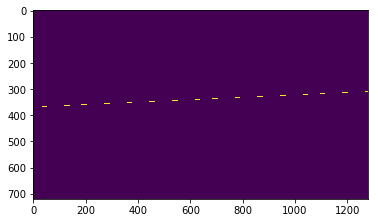

6  -  87
7  -  87
8  -  87
9  -  87
10  -  87
11  -  87
12  -  87


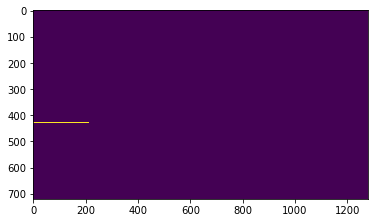

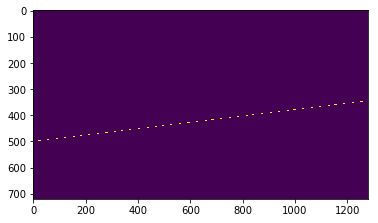

13  -  87


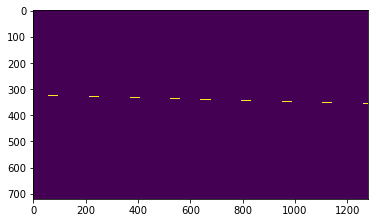

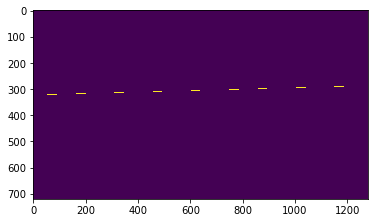

14  -  87
15  -  87
16  -  87
17  -  87
18  -  87
19  -  87
20  -  87
21  -  87
22  -  87
23  -  87
24  -  87


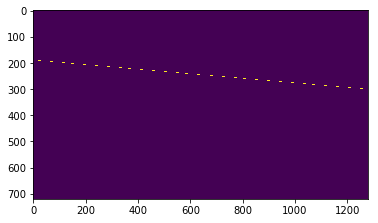

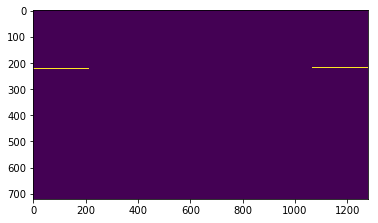

25  -  87
26  -  87
27  -  87
28  -  87


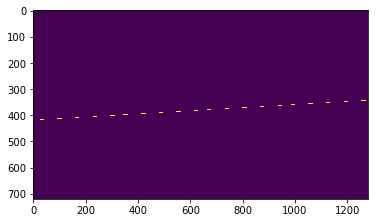

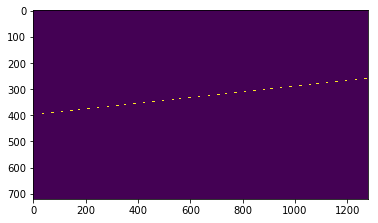

29  -  87


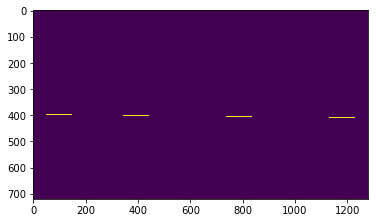

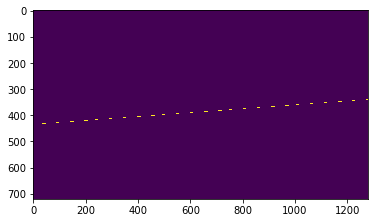

30  -  87
31  -  87


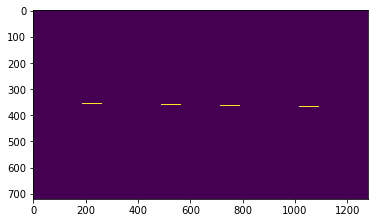

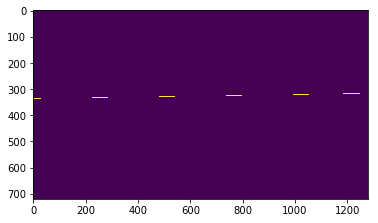

32  -  87
33  -  87
34  -  87
35  -  87


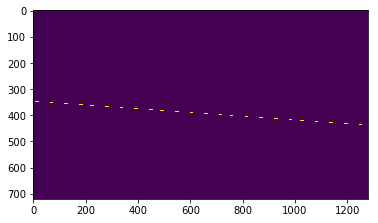

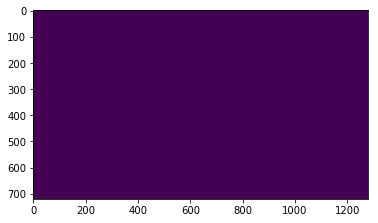

36  -  87


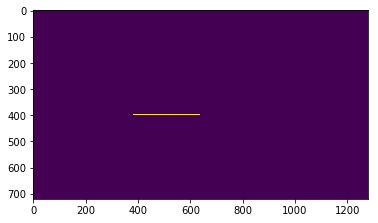

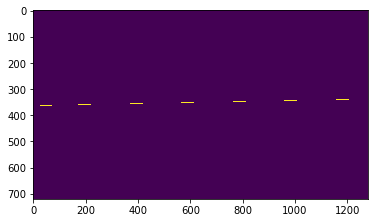

37  -  87
38  -  87


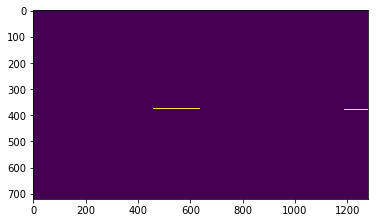

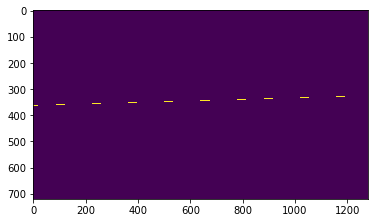

39  -  87


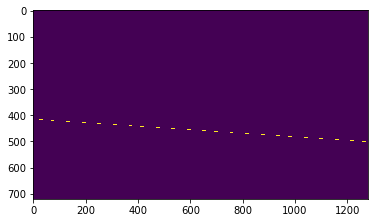

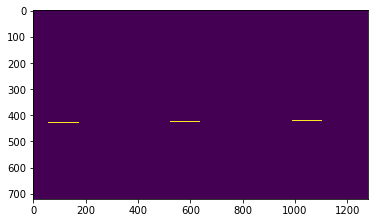

40  -  87


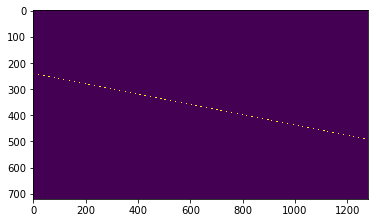

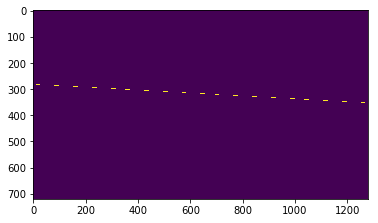

41  -  87
42  -  87
43  -  87
44  -  87
45  -  87
46  -  87
47  -  87


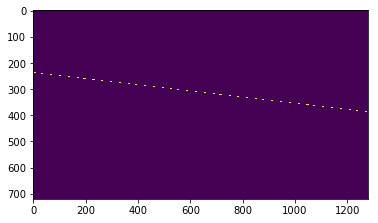

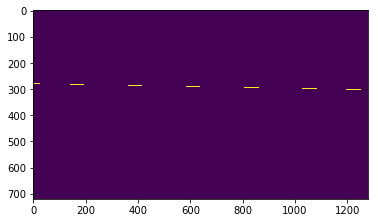

48  -  87


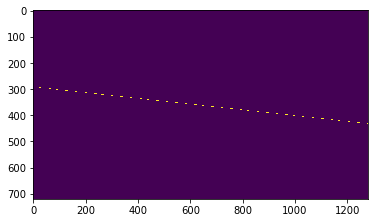

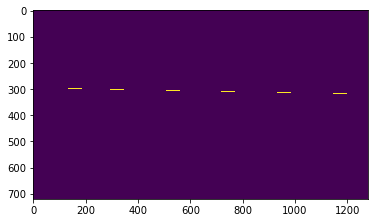

49  -  87


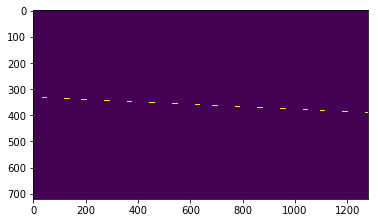

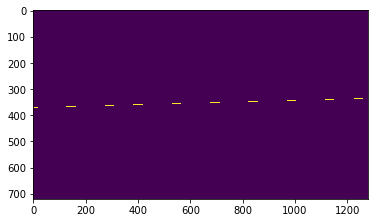

50  -  87


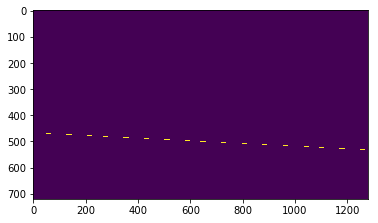

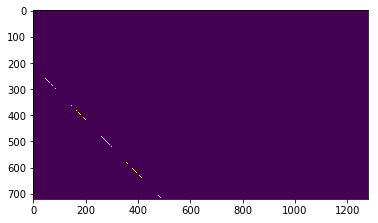

51  -  87
52  -  87


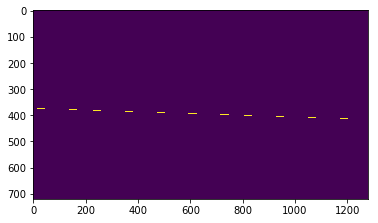

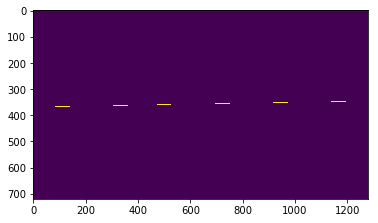

53  -  87
54  -  87
55  -  87
56  -  87
57  -  87
58  -  87


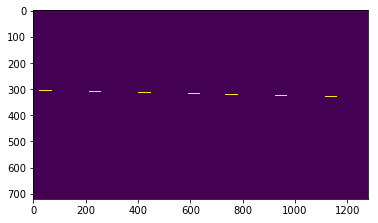

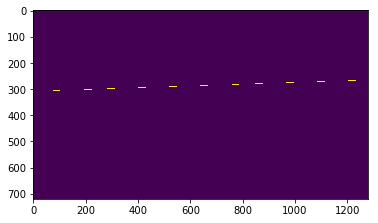

59  -  87


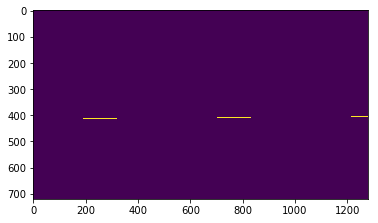

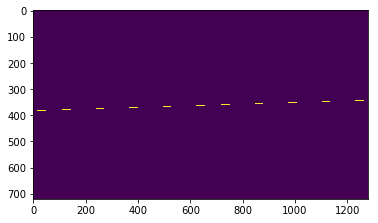

60  -  87


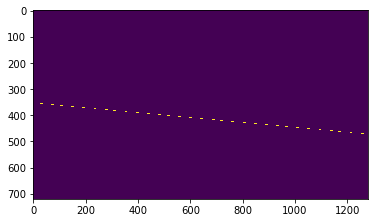

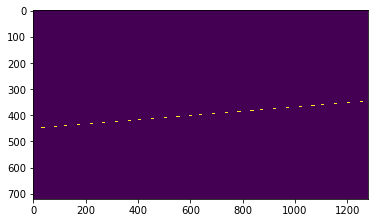

61  -  87


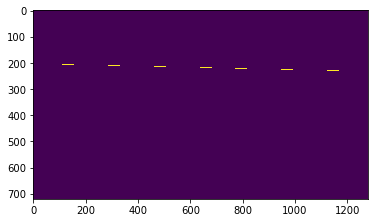

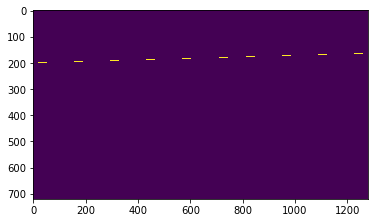

62  -  87
63  -  87
64  -  87
65  -  87
66  -  87
67  -  87
68  -  87
69  -  87


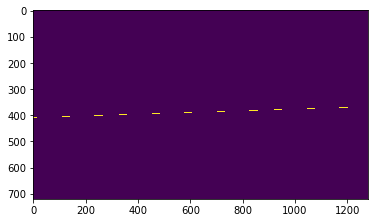

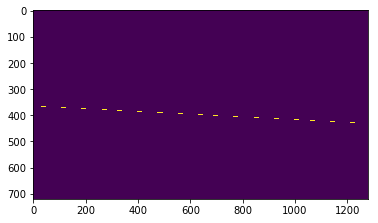

70  -  87
71  -  87


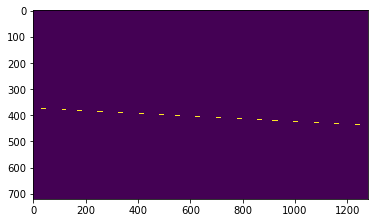

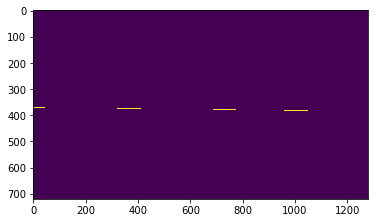

72  -  87


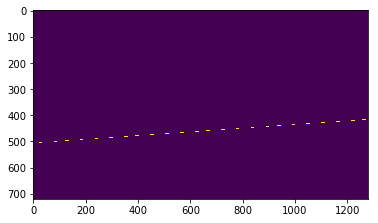

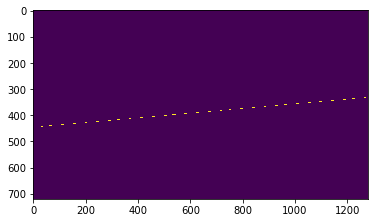

73  -  87
74  -  87


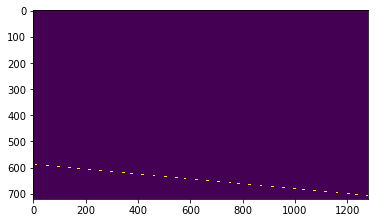

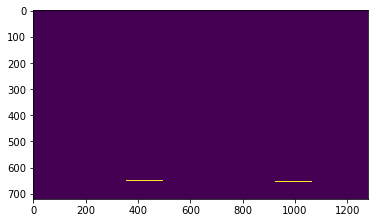

75  -  87
76  -  87
77  -  87
78  -  87
79  -  87


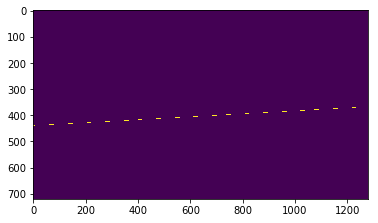

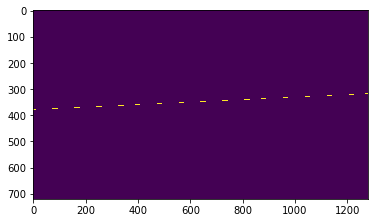

80  -  87


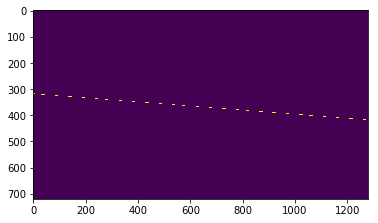

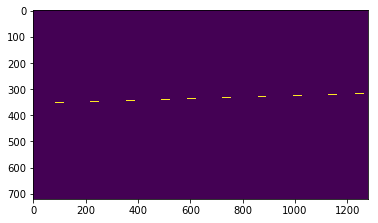

81  -  87


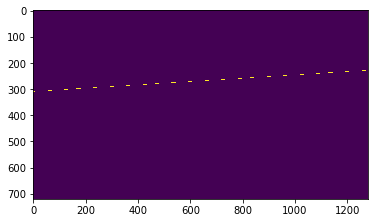

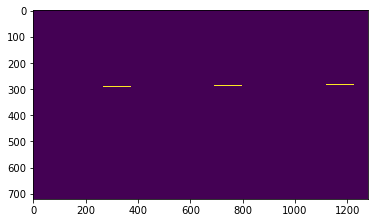

82  -  87
83  -  87


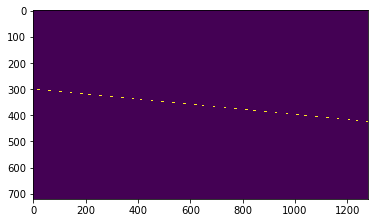

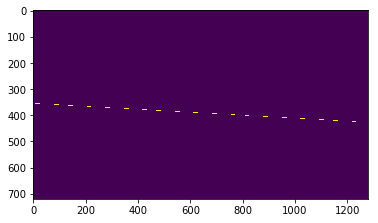

84  -  87


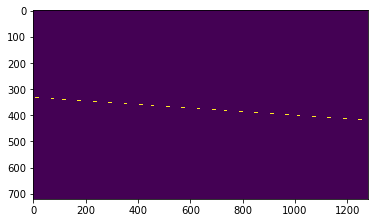

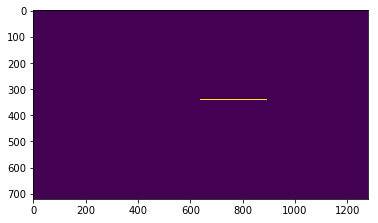

85  -  87
86  -  87
87  -  87
Median error : 43.0


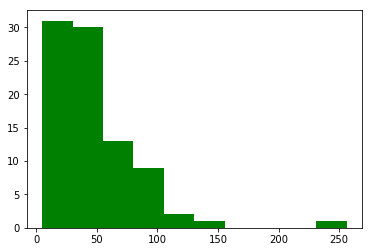

In [25]:
import glob
dataset_annotation=glob.glob("/home/lorenzo/Intcatch/definitivo/test_precision_recall/*annotation.png", recursive=True)
label=[]
pred=[]
avg_distance=[]
max_distance=[]
index=0
for annotation in dataset_annotation:
    index+=1
    print(index," - ",len(dataset_annotation))
    pathRoot=annotation[:annotation.rfind('/')] + '/'
    name_file=(annotation[annotation.rfind('/')+1 : annotation.rfind('-annotation')])
    image=cv2.imread(pathRoot+name_file+".png")
    image = np.array(image)
    height,width,depth=image.shape
    
    
    annotation_image=cv2.imread(annotation)
    annotation_image = cv2.cvtColor(annotation_image, cv2.COLOR_BGR2RGB)
    fit_line = horizon_line_pipeline(annotation_image)
    line_annotation_image = np.zeros([height,width], dtype = "uint8")
    cv2.line(line_annotation_image, (int(fit_line[2]-fit_line[0]*width), int(fit_line[3]-fit_line[1]*width)), (int(fit_line[2]+fit_line[0]*width), int(fit_line[3]+fit_line[1]*width)), (255, 255, 255), 1)
    
    image = cv2.resize(image,(img_w,img_h))
    image = normalized(image)
    image = image[np.newaxis, ...]
    output = model.predict(image)
    prediction_image = visualize(np.argmax(output[0],axis=1).reshape((img_h,img_w)), False)
    prediction_image = cv2.resize(prediction_image,(width,height))
    fit_line = horizon_line_pipeline(prediction_image)
    line_prediction_image = np.zeros([height,width], dtype = "uint8")
    cv2.line(line_prediction_image, (int(fit_line[2]-fit_line[0]*width), int(fit_line[3]-fit_line[1]*width)), (int(fit_line[2]+fit_line[0]*width), int(fit_line[3]+fit_line[1]*width)), (255, 255, 255), 1)
    distance=[]
    for j in range (width):
        for i in range (height):
            if(line_annotation_image[i,j]==255):
                y1=i
            if(line_prediction_image[i,j]==255):
                y2=i
        distance.append(abs(y1-y2))
    
        
    
        
    
    
    avg_distance.append(np.mean(distance)/width)
    max_distance.append(max(distance))
    
    if(max(distance)>50):
        plt.imshow(line_annotation_image)
        plt.show()
        plt.imshow(line_prediction_image)
        plt.show()
        
print("Median error :", np.median(max_distance))
plt.hist(max_distance, facecolor='green')
plt.show()
            